In [4]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism
from astropy.wcs import wcs

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')
# mdb = morph_db.query('1.8 < zgrism < 2.2 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [86]:
mdb.query('id == 21156').zgrism

11    1.25443
Name: zgrism, dtype: float64

In [5]:
GS_seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
GN_seg = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data

GS_f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].data
GN_f125 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')[0].data

In [7]:
w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].header)

In [33]:
p1 = []
p2 = []

for i in range(100):
    x1 = np.random.randint(500)
    y1 = np.random.randint(500)
    
    pos1 = w.wcs_pix2world([[x1,y1], [x1,y1+100]],1)
    x1 = np.random.randint(500)
    y1 = np.random.randint(500)
    pos2 = w.wcs_pix2world([[x1,y1], [x1+100,y1]],1)

    p1.append(np.diff(pos1.T[1])*60*60/100)
    p2.append(-np.diff(pos2.T[0])*60*60/100)

In [87]:
newimg = np.load('../data/imgfiles/GND_21156.npy')

In [89]:
def rescale_img(img,zspec):
    yarc = 100*0.06; xarc = 100*0.068

    ykpc = yarc/cosmo.arcsec_per_kpc_proper(zspec).value
    xkpc = xarc/cosmo.arcsec_per_kpc_proper(zspec).value

    xnew = np.linspace(xkpc/2 - 20, xkpc/2 + 20,100)
    ynew = np.linspace(ykpc/2 - 20, ykpc/2 + 20,100)

    inimg = interp2d(np.arange(1,101,1)*xkpc/100,np.arange(1,101,1)*ykpc/100, newimg)

    return inimg(xnew,ynew)

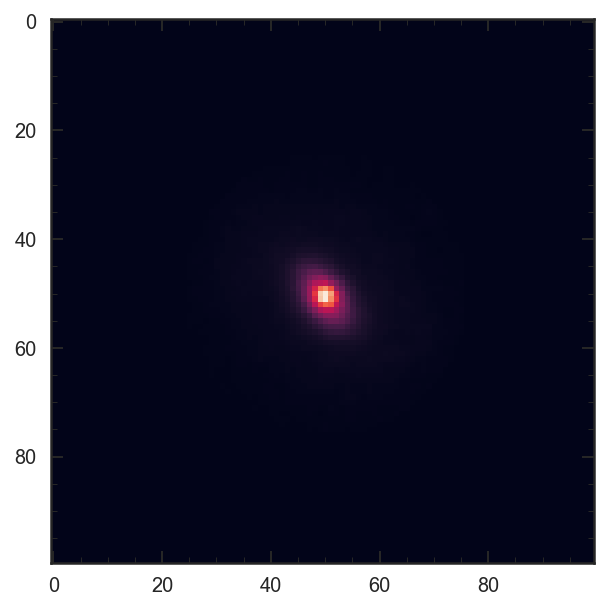

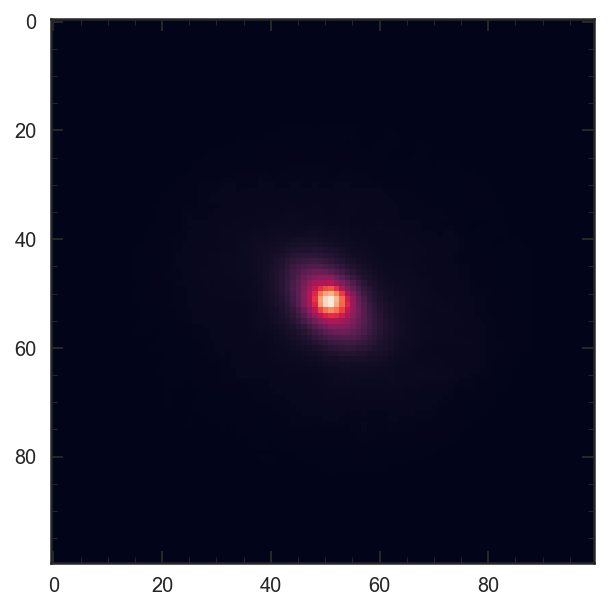

In [90]:
plt.figure(figsize=[5,5])
plt.imshow(newimg)

plt.figure(figsize=[5,5])
plt.imshow(rescale_img(newimg, 1.25443))

In [26]:
fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                17500                                                  
NAXIS2  =                19700                                                  
ORIGIN  = 'SExtractor'         / FITS file originator                           
DATE    = '2013-08-30T14:44:07' / Date FITS file was generated                  
IRAF-TLM= '2013-08-30T14:43:12' / Time of last modification                     
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
NEXTEND =                    1 / Number of standard extensions                  
FILENAME= 'goods-s-f160w-astrodrizzle-v4.0_drz_sci.fits' / name of file         
FILETYPE= 'SCI      '       

In [111]:
cimgs = np.zeros([100,100])
eimgs = np.zeros([100,100])
pixels = np.arange(0, cimgs.shape[0] ,1)

for i in mdb.index:
    newimg = np.load('../data/imgfiles/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    
#     nimg, nlow, nhigh = Light_contours(rescale_img(newimg, mdb.zgrism[i]), lim2 = .95)
    if mdb.compact[i] == 'c':
        cimgs += rescale_img(newimg, mdb.zgrism[i])
    if mdb.compact[i] == 'e':
        eimgs += rescale_img(newimg, mdb.zgrism[i])

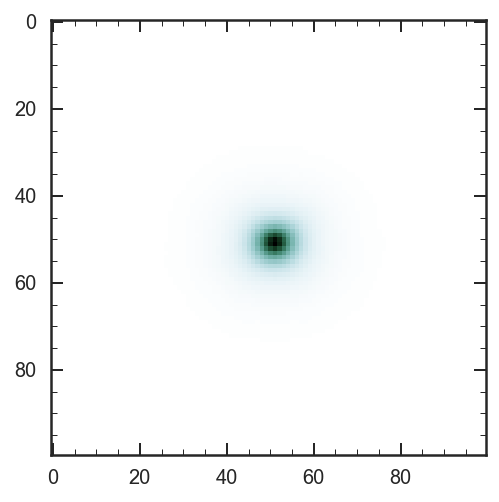

In [112]:
plt.imshow(cimgs, cmap=cmap)

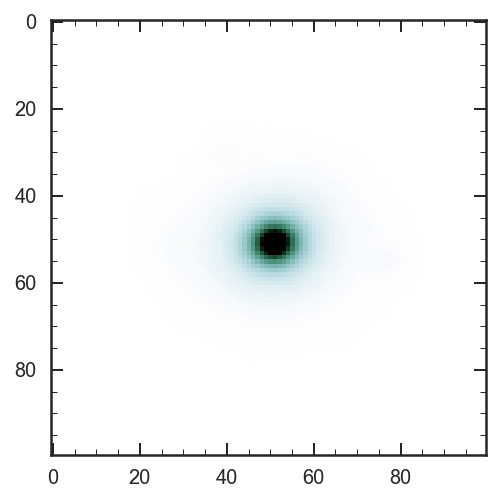

In [114]:
plt.imshow(eimgs, cmap=cmap, vmin = 0, vmax = .5)

In [11]:
for i in mdb.index:
    if mdb.field[i] == 'GND':
        segmap = np.array(GN_seg)
        f125 = np.array(GN_f125)
    else:
        segmap = np.array(GS_seg)
        f125 = np.array(GS_f125)

    idx = np.argwhere(segmap == mdb.id[i])

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = segmap[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f125img = f125[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f125img[segimg != mdb.id[i]] = 0

    ycnt = ylist[np.argmax(np.sum(f125img, axis=1))]
    xcnt = xlist[np.argmax(np.sum(f125img.T, axis=1))]

    f125img = f125[ycnt - 50: ycnt + 50, xcnt - 50: xcnt +50]
    segmask = segimg[ycnt - 50: ycnt + 50, xcnt - 50: xcnt +50]
    f125img[segmask != mdb.id[i]] = 0
    nimg, nlow, nhigh = Light_contours(f125img, lim2 = .95)

    for u in range(1,50,1):
        ring = []
        for uu in range(len(nimg)):
            for uuu in range(len(nimg)):
                if np.round(np.sqrt((uu-50)**2 + (uuu-50)**2),0) == u:
                    ring.append(nimg[uu][uuu])
        if np.mean(ring) < nhigh:
            radius = u
            break

    newimg = np.zeros_like(nimg)

    for u in range(len(newimg)):
        for uu in range(len(newimg)):
            if np.sqrt((u-50)**2 + (uu-50)**2) < radius:
                newimg[u][uu] = nimg[u][uu]
                
    np.save('../data/imgfiles/{0}_{1}'.format(mdb.field[i],mdb.id[i]),newimg)

In [119]:
np.save('../data/compact_img', cimgs)
np.save('../data/extend_img', eimgs)

In [92]:
def Light_contours(img, lim1 = 0.2, lim2 = 0.8):
    pixel_num = img.shape[0]
    pixels = np.arange(0, pixel_num ,1)
    ####### normalize img #########
    nimg = img / np.trapz(np.trapz(img, pixels, axis=1), pixels)
    ####### Create array from highest value of P2 to 0
    pbin = np.linspace(0, np.max(nimg), 1000)
    pbin = pbin[::-1]

    ####### 2d integrate to find the 1 and 2 sigma values
    prob_int = np.zeros(len(pbin))

    for i in range(len(pbin)):
        p = np.array(nimg)
        p[p <= pbin[i]] = 0
        prob_int[i] = np.trapz(np.trapz(p, pixels, axis=1), pixels)

    ######## Identify 0.5 and 95 percentiles
    onesig = np.abs(np.array(prob_int) - lim1)
    twosig = np.abs(np.array(prob_int) - lim2)

    return nimg, pbin[np.argmin(onesig)], pbin[np.argmin(twosig)]

In [115]:
ncimg, clow, chigh = Light_contours(cimgs)
neimg, elow, ehigh = Light_contours(eimgs)

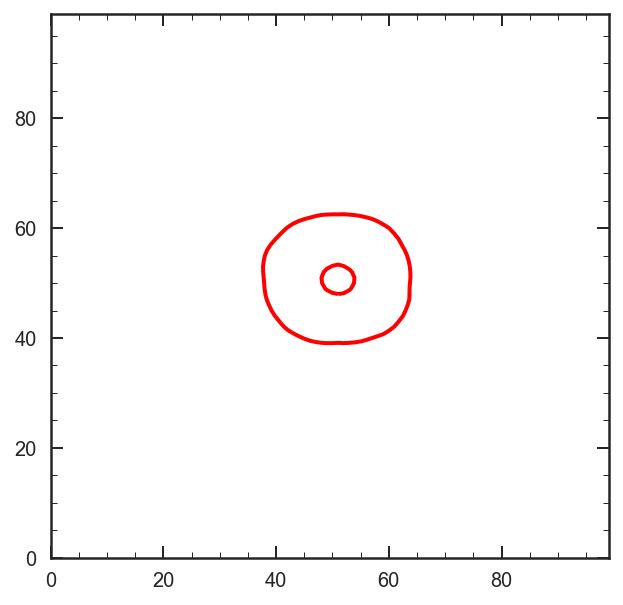

In [116]:
plt.figure(figsize=[5,5])

plt.contour(ncimg,np.array([chigh, clow]),colors='r',linewidths=2)
# plt.contourf(ncimg,40,cmap=cmap)

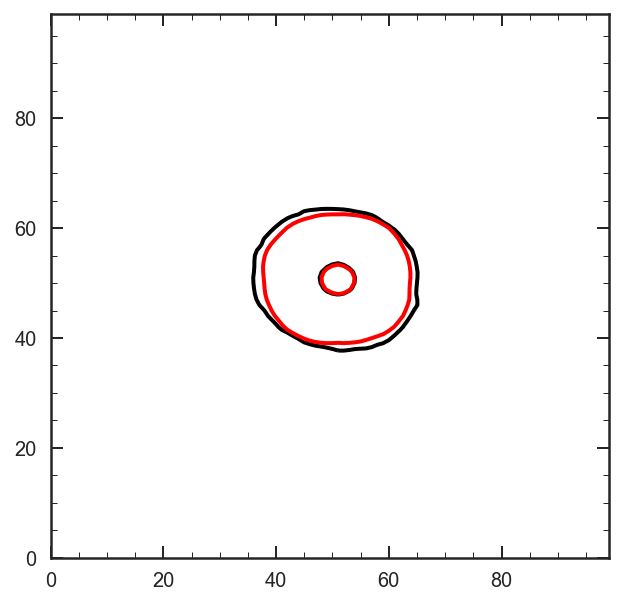

In [117]:
plt.figure(figsize=[5,5])
plt.contour(neimg,np.array([ehigh, elow]),colors='k',linewidths=2)
plt.contour(ncimg,np.array([chigh, clow]),colors='r',linewidths=2)


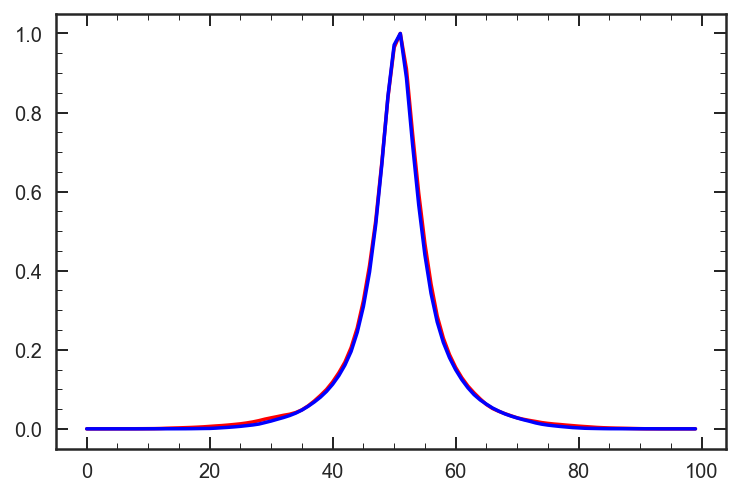

In [118]:
plt.plot(np.sum(eimgs, axis=1)/ max(np.sum(eimgs, axis=1)), 'r')
plt.plot(np.sum(cimgs, axis=1)/ max(np.sum(cimgs, axis=1)),'b')

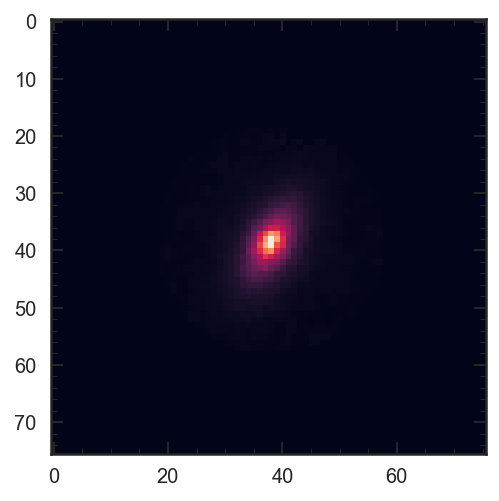

In [288]:
segmap = np.array(GN_seg)
f125 = np.array(GN_f125)

idx = np.argwhere(segmap == 36348)

ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

segimg = segmap[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
f125img = f125[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
f125img[segimg != 36348] = 0
maxloc = np.argwhere(f125img == np.max(f125img))[0]

ycnt = ylist[np.argmax(np.sum(f125img, axis=1))]
xcnt = xlist[np.argmax(np.sum(f125img.T, axis=1))]

f125img = f125[ycnt - 38: ycnt + 38, xcnt - 38: xcnt +38]
segmask = segmap[ycnt - 38: ycnt + 38, xcnt - 38: xcnt +38]
f125img[segmask != 36348] = 0

nimg, nlow, nhigh = Light_contours(f125img, lim2 = .95)

for u in range(1,38,1):
    ring = []
    for i in range(len(nimg)):
        for ii in range(len(nimg)):
            if np.round(np.sqrt((i-38)**2 + (ii-38)**2),0) == u:
                ring.append(nimg[i][ii])
    if np.mean(ring) < nhigh:
        radius = u
        break

newimg = np.zeros_like(nimg)

for i in range(len(newimg)):
    for ii in range(len(newimg)):
        if np.sqrt((i-38)**2 + (ii-38)**2) < radius:
            newimg[i][ii] = nimg[i][ii]

nimg, nlow, nhigh = Light_contours(newimg, lim2 = .95)

plt.figure()
plt.imshow(nimg)


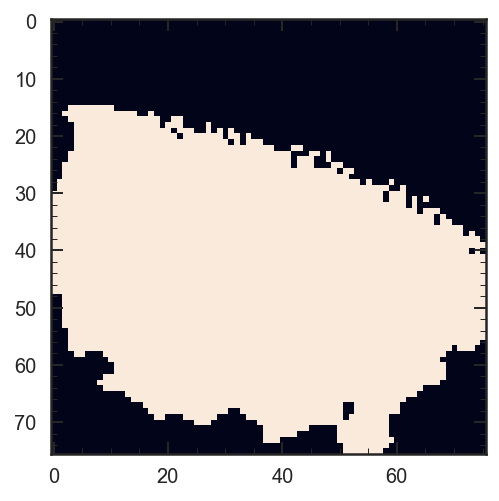

In [132]:
segmask[segmask != 27714] = 0
plt.imshow(segmask)

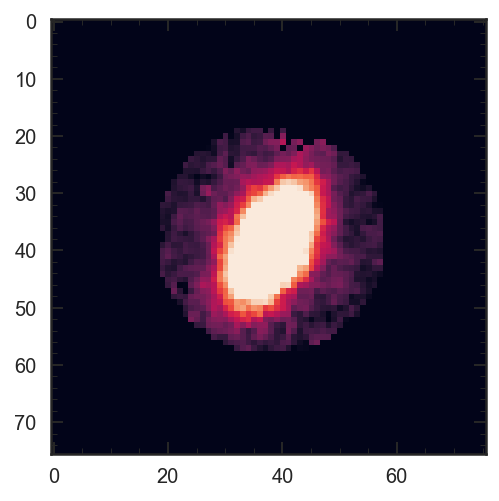

In [289]:
plt.imshow(nimg, vmin = 0, vmax=0.001)


In [262]:
ntimg, tlow, thigh = Light_contours(nimg, lim2 = .95)


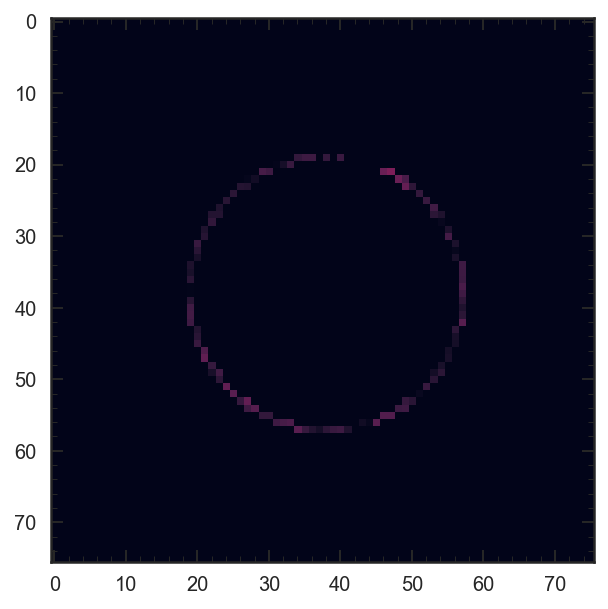

In [280]:
plt.figure(figsize=[5,5])
# plt.contour(ntimg,np.array([thigh, tlow]),colors='r',linewidths=2)
# plt.imshow(nimg, vmin = 0, vmax=0.001)
plt.imshow(newimg, vmin = 0, vmax=0.001)


## stack

In [123]:
flxgrid = []
errgrid = []
swave = np.arange(3000,8000,10)

for i in mdb.index:
    if mdb.compact[i] == 'e':
        field = mdb.field[i]
        galaxy = mdb.id[i]

        m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
        bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
            '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

        Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 

        wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

        sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
        sp.params['dust2'] = d
        sp.params['dust1'] = d
        sp.params['logzsol'] = np.log10(m)

        time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

        sp.set_tabular_sfh(time,sfr)    

        wave, flux = sp.get_spectrum(tage = a, peraa = True)    

        Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z, 
                                        wvs, flxs, errs, beams, trans)
        
        MFLX = F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm

        IDX = [U for U in range(len(wave)) if 3000 < wave[U] < 6000]

        Nfact = np.trapz(MFLX[IDX],wave[IDX])
        
        sidx = 0
        sflux = np.zeros(len(swave))
        serror = np.zeros(len(swave))
        
        
        if Gs.g102:
            bcal = Calibrate_grism([wvs[sidx], flxs[sidx], errs[sidx]], Gmfl[sidx], bp1)[0]
            bscale = Scale_model( flxs[sidx] / bcal,errs[sidx]/ bcal,Gmfl[sidx])
            iBflx =interp1d(Gs.Bwv_rf,flxs[sidx] / bcal/ bscale / Nfact, fill_value=0, bounds_error=False)(swave)
            iBerr =interp1d(Gs.Bwv_rf,errs[sidx] / bcal/ bscale / Nfact, fill_value=0, bounds_error=False)(swave)
            sflux += iBflx
            serror += iBerr
            
            sidx += 1
            
        if Gs.g141:
            rcal = Calibrate_grism([wvs[sidx], flxs[sidx], errs[sidx]], Gmfl[sidx], rp1)[0]
            rscale =Scale_model( flxs[sidx] / rcal,errs[sidx]/ rcal,Gmfl[sidx])
            iRflx =interp1d(Gs.Rwv_rf,flxs[sidx] / rcal/ rscale / Nfact, fill_value=0, bounds_error=False)(swave)
            iRerr =interp1d(Gs.Rwv_rf,errs[sidx] / rcal/ rscale / Nfact, fill_value=0, bounds_error=False)(swave)
            sflux += iRflx
            serror += iRerr

        serror[serror == 0] = 1E5
        
        flxgrid.append(sflux)
        errgrid.append(serror)        

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/minico

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/minico

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/minico

missing g141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/minico

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/e

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/e

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [121]:
def Stack(wv, flxgrid , errgrid):
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

In [124]:
seflux, seerror = Stack(swave, flxgrid, errgrid)

<ErrorbarContainer object of 3 artists>

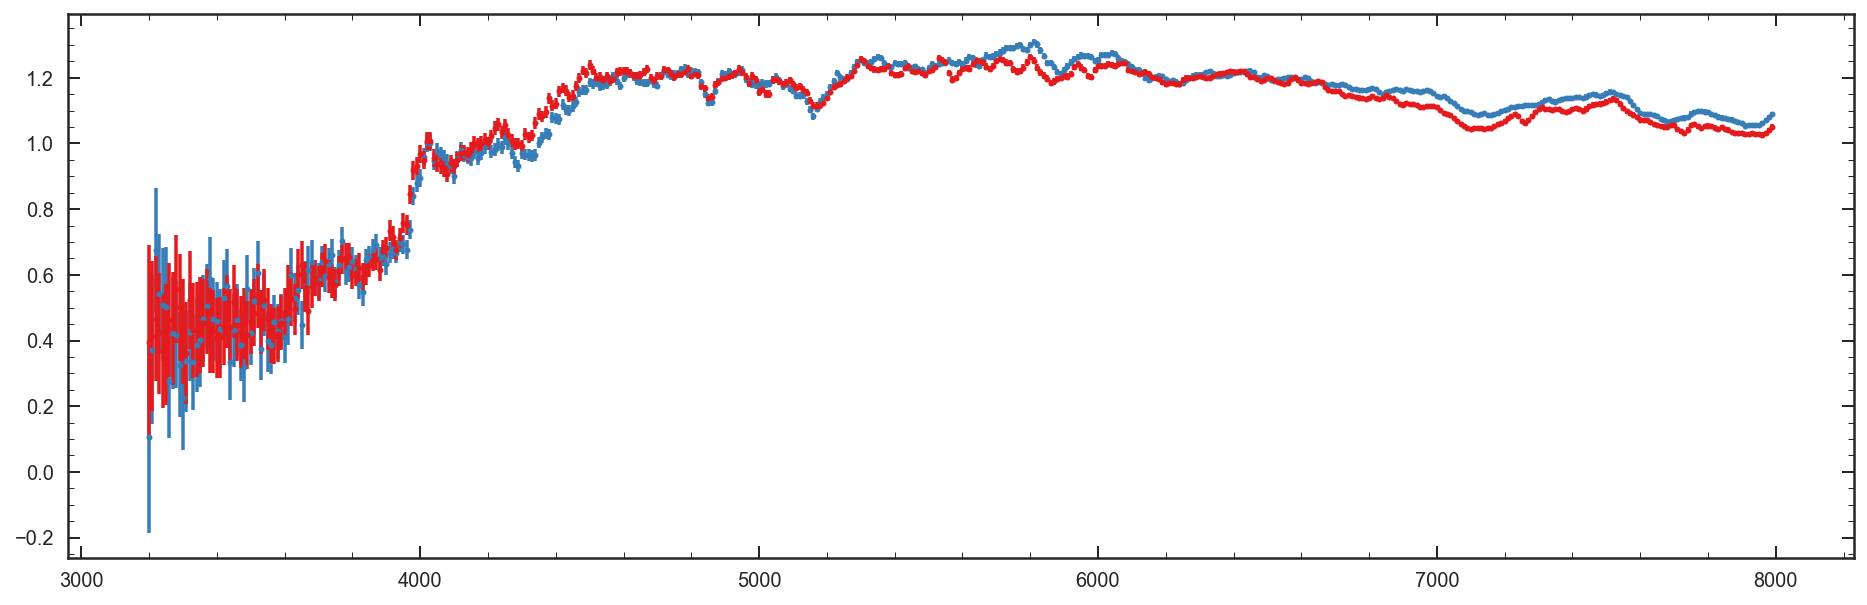

In [128]:
plt.figure(figsize=[16,5])

plt.errorbar(swave[20:], scflux[20:] / scflux[120], scerror[20:]/ scflux[120],
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
plt.errorbar(swave[20:], seflux[20:] / seflux[120], scerror[20:] / seflux[120],
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)


In [129]:
np.save('../data/compact_spec', [swave[20:], scflux[20:] / scflux[120], scerror[20:] / scflux[120]])
np.save('../data/extended_spec', [swave[20:], seflux[20:] / seflux[120], scerror[20:] / seflux[120]])

In [5]:
plt.figure(figsize=[16,5])
###############plot tab##################

if Gs.g102:
    plt.errorbar(Gs.Bwv_rf,flxs[0]/ bcal/bscale / Nfact,errs[0] / bcal/bscale / Nfact,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)

if Gs.g141:
    plt.errorbar(Gs.Rwv_rf,flxs[1]/  rcal /rscale / Nfact,errs[1] / rcal/rscale / Nfact,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)


plt.title(galaxy, fontsize=25)
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)



IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 1152x360 with 0 Axes>

<ErrorbarContainer object of 3 artists>

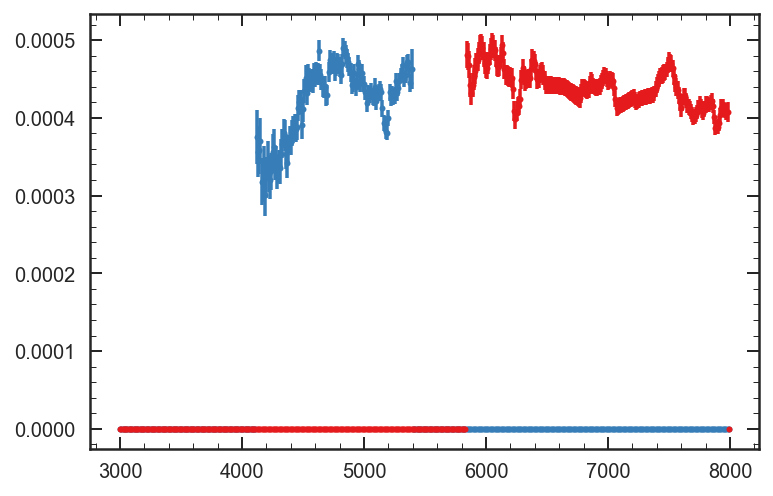

In [36]:
plt.errorbar(swave, iBflx, iBerr,
        linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)

plt.errorbar(swave, iRflx, iRerr,
        linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)

(0, 0.0006)

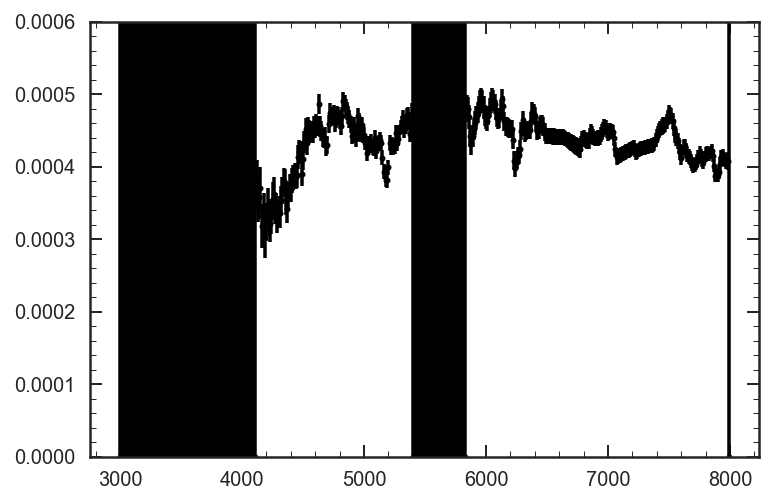

In [38]:
plt.errorbar(swave, sflux, serror,
        linestyle='None', marker='o', markersize=3, color='k', zorder = 2)
plt.ylim(0,0.0006)

# plot spec

In [2]:
cimg = np.load('../data/compact_img.npy')
eimg = np.load('../data/extend_img.npy')

cwave, cflux, cerror = np.load('../data/compact_spec.npy')
ewave, eflux, eerror = np.load('../data/extended_spec.npy')

In [5]:
ncimg, clow, chigh = Light_contours(cimg)
neimg, elow, ehigh = Light_contours(eimg)

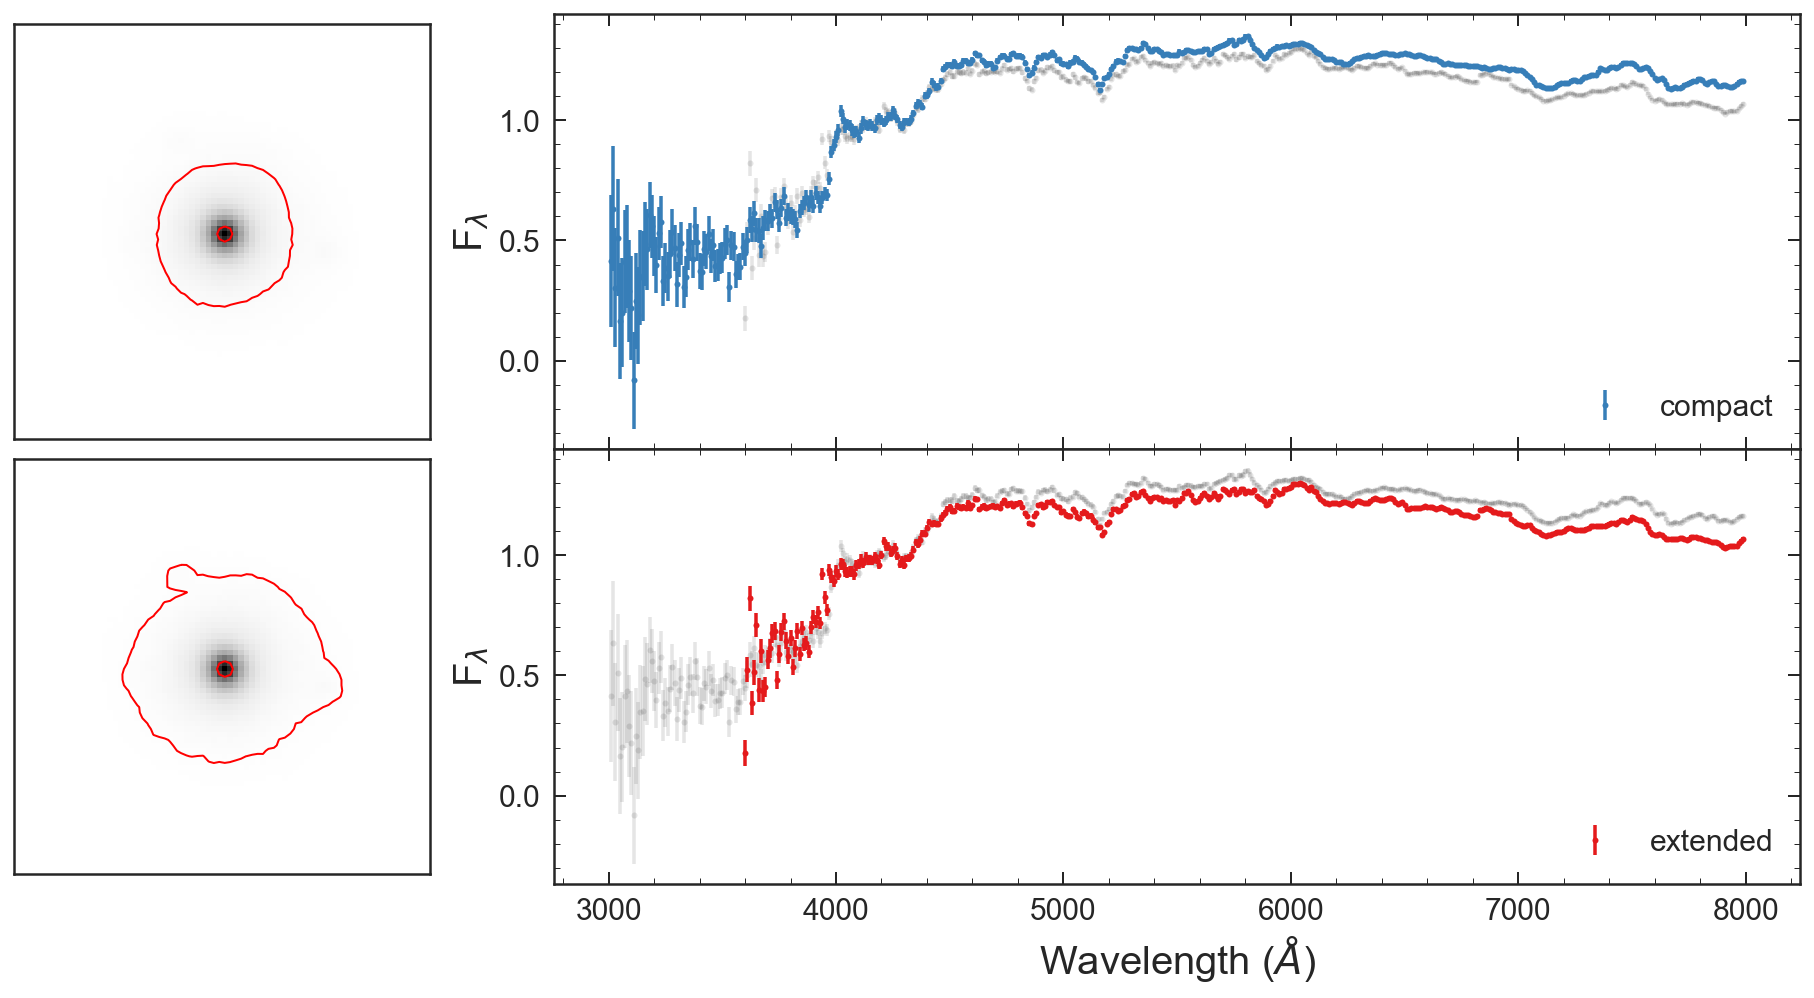

In [7]:
gs = gridspec.GridSpec(2,2, width_ratios=[1,3], hspace=0, wspace = 0.15)

plt.figure(figsize=[16,8])

plt.subplot(gs[0,0])
plt.imshow(np.arcsinh(eimg), cmap= 'binary')
plt.contour(ncimg,np.array([chigh, clow]),colors='r',linewidths=1)
plt.xticks([])
plt.yticks([])

plt.subplot(gs[0,1])
plt.errorbar(cwave, cflux, cerror,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2, label = 'compact')
plt.errorbar(ewave, eflux, eerror,
            linestyle='None', marker='o', markersize=3, color='k', alpha = 0.1, zorder = 1)

plt.legend(fontsize = 15, loc = 4)
plt.ylabel('F$_\lambda$', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplot(gs[1,0])
plt.imshow(eimg, cmap= 'binary')
plt.contour(neimg,np.array([ehigh, elow]),colors='r',linewidths=1)
plt.xticks([])
plt.yticks([])

plt.subplot(gs[1,1])
plt.errorbar(cwave, cflux, cerror,
            linestyle='None', marker='o', markersize=3, color='k', alpha = 0.1, zorder = 1)
plt.errorbar(ewave, eflux, eerror,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2, label = 'extended')
plt.legend(fontsize = 15, loc = 4)
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/morph/com_ext_spec.png', bbox_inches = 'tight')

In [60]:
np.max(cimg)

0.783295732922852